In [16]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import re
import scipy.stats as stats
import json
import matplotlib.pylab as pl

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

In [27]:
def exponential_cov(x, y, *args):
    assert len(args) >= 2, "need more 2 or more params for exponential kernel, got %i"%(len(args))
    return args[0] * np.exp( -0.5 * args[1] * np.subtract.outer(x, y)**2)

In [28]:
def conditional(x_new, x, y, params):
    
    B = exponential_cov(x_new, x, *params)
    C = exponential_cov(x, x, *params)
    A = exponential_cov(x_new, x_new, *params)

    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))

    return(mu.squeeze(), sigma.squeeze())

In [29]:
xpts = np.linspace(-15, 5, num=1000)
XX = np.zeros(shape=(len(xpts), len(xpts)), dtype=np.float64)
theta = [1,2]

for i, row in enumerate(XX):
    for j, col in enumerate(row):
        
        XX[i,j] = exponential_cov(xpts[i], xpts[j], *theta)

In [30]:
process = stats.multivariate_normal(np.zeros_like(xpts), XX, allow_singular=True)

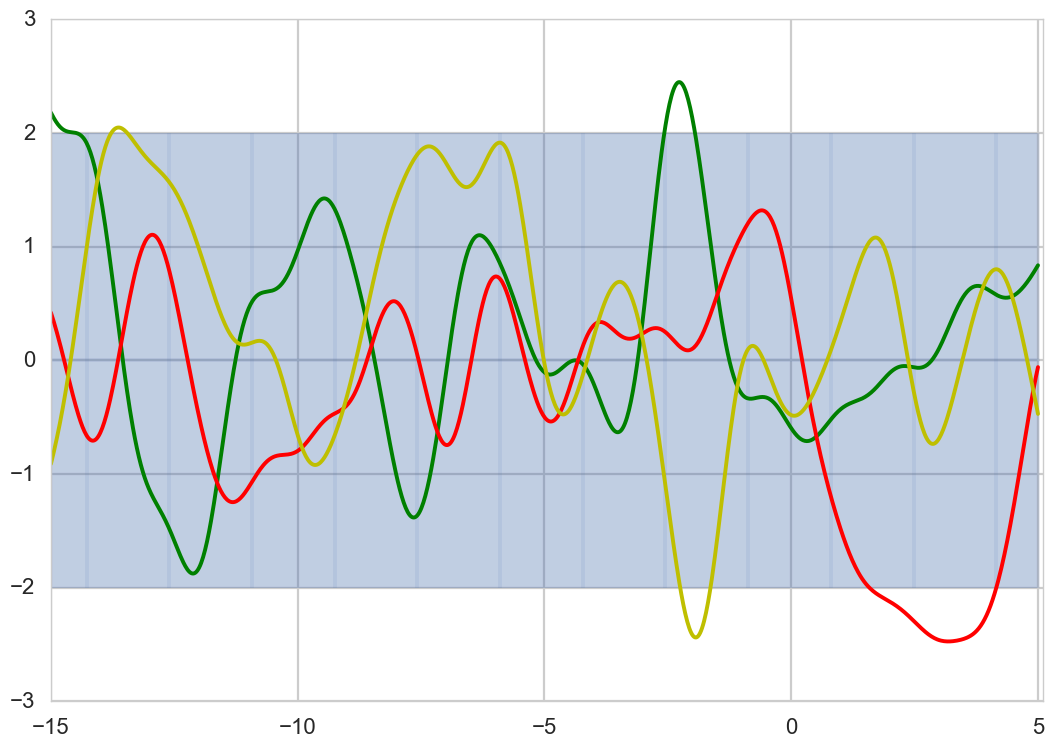

In [31]:
theta = [1, 2]
sig_0 = exponential_cov(0, 0, *theta)

pl.errorbar(xpts, np.zeros(len(xpts)), yerr=2*sig_0, capsize=0, alpha=0.1)
plt.ylim([-3,3])
plt.xlim([-15,5.1])

# make three draws from the prior_predictive

vec1 = process.rvs()
vec2 = process.rvs()
vec3 = process.rvs()

plt.plot(xpts, vec1, c='g')
plt.plot(xpts, vec2, c='r')
plt.plot(xpts, vec3, c='y')

plt.show()

# now observe the data

In [32]:
data = [[-4,-2],[-3,0],[-1,1],[0,2],[2,-1]]

In [33]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, *params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, *params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

sig_1 = exponential_cov([d[0] for d in data], [d[0] for d in data], *theta)
x_pred = np.linspace(-15, 5, 1000)
predictions = [predict(i, [d[0] for d in data], exponential_cov, theta, sig_1, [d[1] for d in data]) for i in x_pred]

Use the formula to calculate the predicted kernel conditioned on the training data.

In [77]:
# mean vec
K_X_star_X = np.zeros(shape=(len(x_pred), len(data)))

for i, row in enumerate(K_X_star_X):
    for j, col in enumerate(row):
        K_X_star_X[i,j] = exponential_cov(x_pred[i], data[j][0], *theta)
        
K_X_X = np.zeros(shape=(len(data), len(data)))
for i, row in enumerate(K_X_X):
    for j, col in enumerate(row):
        K_X_X[i,j] = exponential_cov(data[i][0], data[j][0], *theta)
        
K_K_inv = np.dot(K_X_star_X, np.linalg.pinv(K_X_X))
mean_vec = np.dot(K_K_inv, np.array([d[1] for d in data]))

In [78]:
# cov matrix
K_X_star_X_star = np.zeros(shape=(len(x_pred), len(x_pred)))
for i, row in enumerate(K_X_star_X_star):
    for j, col in enumerate(row):
        K_X_star_X_star[i,j] = exponential_cov(x_pred[i], x_pred[j], *theta)
        
K_X_Xstar = np.zeros(shape=(len(data), len(x_pred)))
for i, row in enumerate(K_X_Xstar):
    for j, col in enumerate(row):
        K_X_Xstar[i,j] = exponential_cov(data[i][0], x_pred[j], *theta)

In [79]:
cov_matrix = K_X_star_X_star - np.dot(K_K_inv, K_X_Xstar)

In [80]:
process = stats.multivariate_normal(mean_vec, cov_matrix, allow_singular=True)

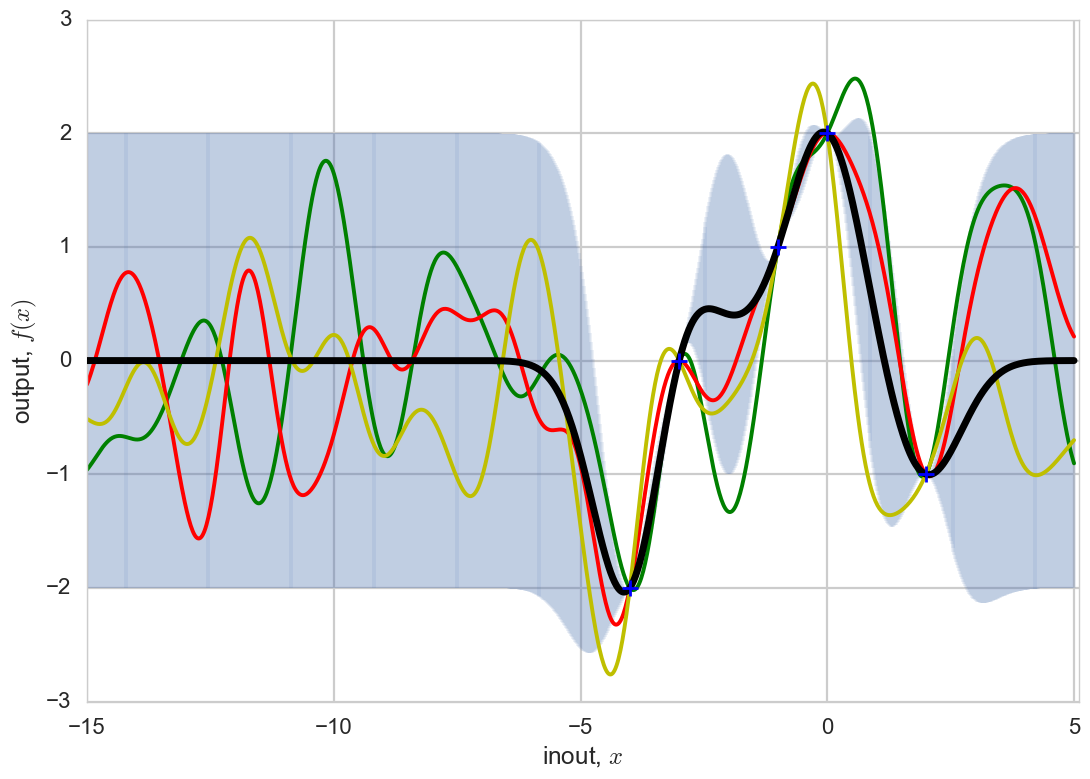

In [88]:
pl.errorbar(x_pred, [predictions[i][0] for i in range(len(predictions))], yerr=[2*predictions[i][1] for i in range(len(predictions))], capsize=0, alpha=0.1)
plt.plot(x_pred, [predictions[i][0] for i in range(len(predictions))], zorder=100, c='black', lw=5)

plt.scatter([d[0] for d in data], [d[1] for d in data], marker='+', lw=2, s=120, zorder=200, c='blue')

plt.ylim([-3,3])
plt.xlim([-15,5.1])

# make three draws from the prior_predictive

vec1 = process.rvs()
vec2 = process.rvs()
vec3 = process.rvs()

plt.plot(x_pred, vec1, c='g')
plt.plot(x_pred, vec2, c='r')
plt.plot(x_pred, vec3, c='y')

plt.xlabel('inout, $x$')
plt.ylabel('output, $f(x)$')
plt.show()

A note for the above is that we probably would rather use the Cholesky decomposition rather than the pinv.